In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
import json
from tqdm import tqdm
import seaborn as sns
sns.set_theme()
sns.set(font_scale=0.8)

from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

import sys
sys.path.append('/Users/smiskov/Documents/SLAC/PVInsight/solar-data-tools/tests/fixtures/signal_decompositions/')
from utils import plot_decomp, plot_signal
import cvxpy as cvx

np.random.seed(12) 

In [2]:
%load_ext autoreload
%autoreload 2

# Create data

In [5]:
# create mix of piecewise fns
# create mix of sinusoids data
ws = [165, 660, 330]
period = 660

t = np.arange(period*15)
X_real = np.zeros((4, len(t)), dtype=float)

for i in range(3):
    w = ws[i]
    X_real[i] = signal.square(2 * np.pi * t * 1 / w)  

# noise
X_real[3] = 0.15 * np.random.randn(len(t))

signal_large = np.sum(X_real, axis=0)

# for reference
gt = np.sum(X_real[:3], axis=0)

In [6]:
X_real.shape

(4, 9900)

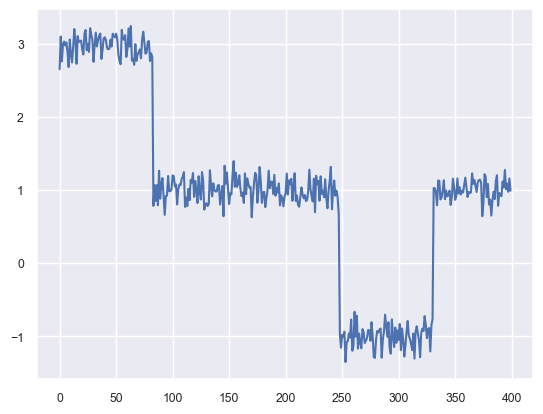

In [7]:
plt.plot(signal_large[:400]);

In [8]:
signal_small = signal_large[:period*1]
signal_medium = signal_large[:period*5]

# Define SD problem

In [9]:
def l2_l1d1_periodic(
    signal,
    weight,
    l2="norm", # or "sumsquares"
    scale=False,
    period=period, # not used yet
    solver=None,
    periodic=False
):
    l2_func = {"norm" : cvx.norm,
               "sumsquares" : cvx.sum_squares
              }
    
    scale_err = 1/len(signal) if scale else 1
    
    s_hat = cvx.Variable(len(signal))
    s_error = cvx.Variable(len(signal))
    weight = cvx.Constant(value=weight)
    scale_err = cvx.Constant(value=scale_err)
    
    objective = cvx.Minimize(
        scale_err * l2_func[l2](s_error)
      + weight *  cvx.norm1(cvx.diff(s_hat, k=1))
    )

    # Consistency and periodicity constraints
    constraints = [
        signal == s_hat + s_error
    ]
    if periodic and len(signal)>period:
        constraints.append(s_hat[period:] - s_hat[:-period] == 0)

    problem = cvx.Problem(objective=objective, constraints=constraints)
    problem.solve(solver=solver)
    
    return s_hat.value, s_error.value, problem.objective.value

# Set original decomposition (using cvx.norm) on medium len signal

In [10]:
weight_or_iter = np.linspace(1e-6, 0.1, 25)
for w in weight_or_iter:
    s_hat, s_err, obj = l2_l1d1_periodic(signal_medium, weight=w, l2="norm", scale=False, periodic=True)
    mae_s_hat = mae(s_hat, np.sum(X_real[:3], axis=0)[:len(signal_medium)])
    mse_s_err = mse(s_err, X_real[3][:len(signal_medium)], squared=False)
    print(f"{w:.5f}, {mae_s_hat:.5f}, {mse_s_err:.5f}")

0.00000, 0.06048, 0.13687
0.00417, 0.03379, 0.12436
0.00833, 0.02446, 0.12149
0.01250, 0.02057, 0.12063
0.01667, 0.01862, 0.12030
0.02083, 0.01722, 0.12014
0.02500, 0.01629, 0.12005
0.02917, 0.01573, 0.11999
0.03333, 0.01530, 0.11997
0.03750, 0.01526, 0.11998
0.04167, 0.01552, 0.12000
0.04583, 0.01585, 0.12003
0.05000, 0.01638, 0.12007
0.05417, 0.01692, 0.12012
0.05833, 0.01745, 0.12018
0.06250, 0.01799, 0.12025
0.06667, 0.01853, 0.12032
0.07083, 0.01906, 0.12040
0.07500, 0.01960, 0.12049
0.07917, 0.02014, 0.12058
0.08333, 0.02068, 0.12069
0.08750, 0.02122, 0.12079
0.09167, 0.02176, 0.12091
0.09583, 0.02230, 0.12103
0.10000, 0.02285, 0.12116


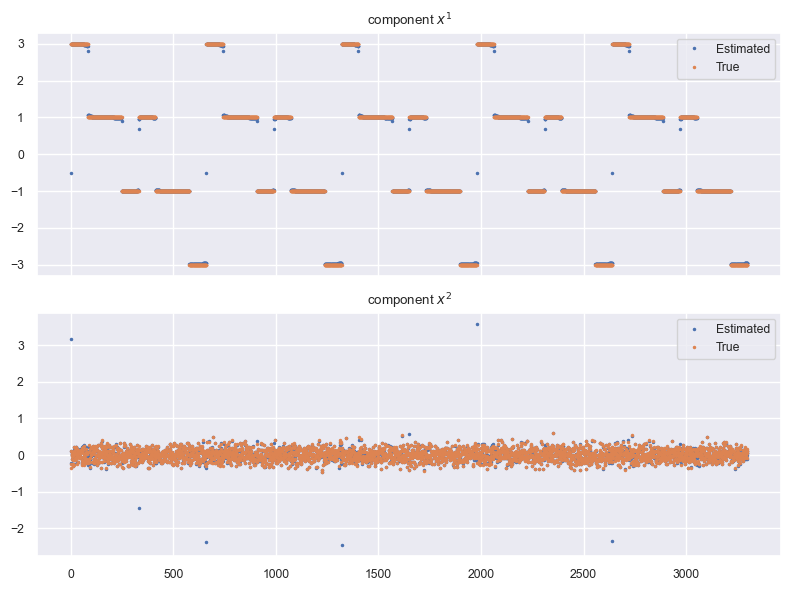

In [11]:
s_hat, s_err, obj = l2_l1d1_periodic(signal_medium, weight=0.04167, l2="norm", scale=False, periodic=True)
plot_decomp([s_hat, s_err], [np.sum(X_real[:3], axis=0)[:len(signal_medium)], X_real[3][:len(signal_medium)]])

# Run comparison

In [55]:
results = {}
weight_iter_unscaled = np.logspace(-0.5, 0.5, 12)
weight_iter_scaled = np.logspace(-4.5, -2.5, 12)

In [56]:
def run(sig, run_type, scale, periodic=False):
    results[run_type] = {}
    weight_iter = weight_iter_scaled if scale else weight_iter_unscaled
    
    # # get original decomposition
    # s_hat, s_err, obj = l2_l1d1_periodic(sig, weight=0.04167, l2="norm", scale=scale, periodic=periodic)
    # results[run_type]["norm"] = {"s_hat": s_hat, "s_err": s_err, "obj": obj} 

    # results with sum_squares
    mae_s_hat_list, rmse_s_err_list = [], []
    for w in tqdm(weight_iter):
        s_hat_ss, s_err_ss, _ = l2_l1d1_periodic(sig, weight=w, l2="sumsquares", scale=scale, periodic=periodic)
        mae_s_hat_list.append(mae(np.sum(X_real[:3], axis=0)[:len(sig)], s_hat_ss))
        
    results[run_type]["weight_min"] =  weight_iter[np.argmin(mae_s_hat_list)]
    results[run_type]["mae_s_hat_list"] = mae_s_hat_list

In [57]:
# Small len without scaling
run(signal_small, "Small Len.", scale=False, periodic=True)

# Medium len without scaling
run(signal_medium, "Med. Len.", scale=False, periodic=True)

# Large len without scaling
run(signal_large, "Large Len.", scale=False, periodic=True)

# Small len with scaling
run(signal_small, "Small Len. Scaled", scale=True, periodic=True)

# Medium len with scaling
run(signal_medium, "Med. Len. Scaled", scale=True, periodic=True)

# Large len with scaling
run(signal_large, "Large Len. Scaled", scale=True, periodic=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:30<00:00,  2.50s/it]


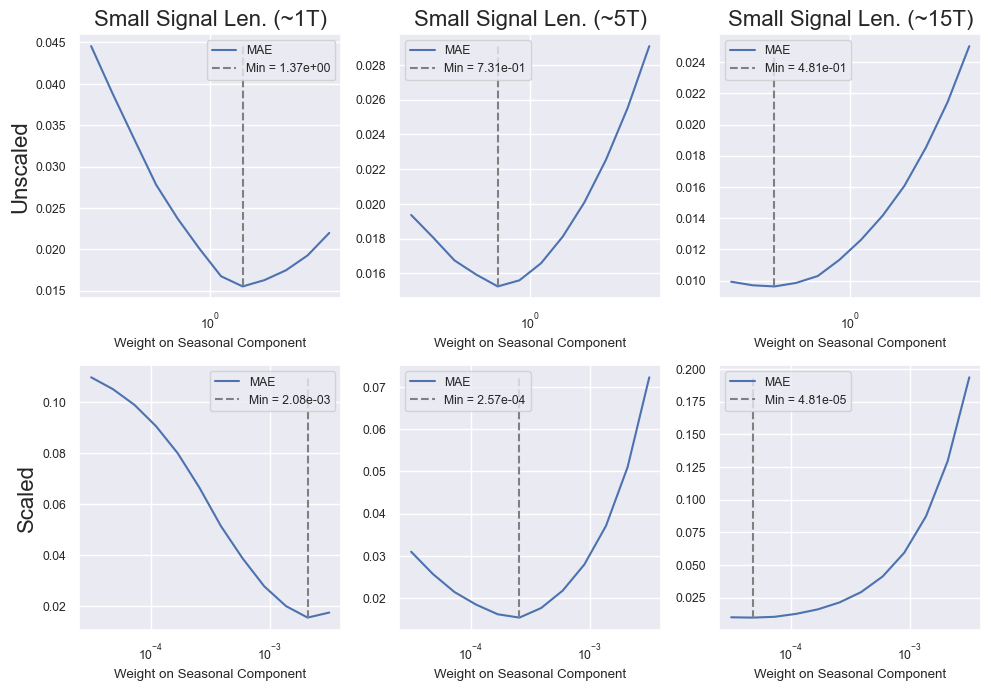

In [64]:
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=False, figsize=(10,7))

res_k = list(results.keys())

for ax_ in ax:
    for ax__, k in zip(ax_, res_k):
        weight_iter = weight_iter_unscaled if k in list(results.keys())[:3] else weight_iter_scaled
        ax__.plot(weight_iter, results[k]["mae_s_hat_list"], label="MAE")
        ax__.vlines(results[k]["weight_min"], min(results[k]["mae_s_hat_list"]), max(results[k]["mae_s_hat_list"]), label=f'Min = {results[k]["weight_min"]:.2e}',
                linestyle="--", color="gray")
        ax__.legend()
    res_k = res_k[3:]
        
ax[0][0].set_ylabel(r"Unscaled", fontsize=16)
ax[1][0].set_ylabel("Scaled", fontsize=16)
ax[0][0].set_title("Small Signal Len. (~1T)", fontsize=16)
ax[0][1].set_title("Small Signal Len. (~5T)", fontsize=16)
ax[0][2].set_title("Small Signal Len. (~15T)", fontsize=16)

for ax_ in ax[1]:
    ax_.set_xlabel("Weight on Seasonal Component")
    ax_.set_xscale("log")
for ax_ in ax[0]:
    ax_.set_xlabel("Weight on Seasonal Component")
    ax_.set_xscale("log")

plt.tight_layout()

In [61]:
runs = ['Small Len.', 'Med. Len.', 'Large Len.', 'Small Len. Scaled', 'Med. Len. Scaled', 'Large Len. Scaled']

# unscaled, weight = 8.86e-1
weight_unscaled = 7.31e-1

results[runs[0]]["s_seas_med"] , results[runs[0]]["s_err_med"], _ = l2_l1d1_periodic(signal_small,
                                                                                     weight=weight_unscaled, 
                                                                                     l2="sumsquares", 
                                                                                     scale=False)

results[runs[1]]["s_seas_med"] , results[runs[1]]["s_err_med"], _ = l2_l1d1_periodic(signal_medium,
                                                                                     weight=weight_unscaled, 
                                                                                     l2="sumsquares", 
                                                                                     scale=False)

results[runs[2]]["s_seas_med"] , results[runs[2]]["s_err_med"], _ = l2_l1d1_periodic(signal_large,
                                                                                     weight=weight_unscaled, 
                                                                                     l2="sumsquares", 
                                                                                     scale=False)

                 
# scaled, weight = 1.83e-4
weight_scaled = 2.57e-4

results[runs[3]]["s_seas_med"] , results[runs[3]]["s_err_med"], _ = l2_l1d1_periodic(signal_small,
                                                                                     weight=weight_scaled, 
                                                                                     l2="sumsquares", 
                                                                                     scale=True)

results[runs[4]]["s_seas_med"] , results[runs[4]]["s_err_med"], _ = l2_l1d1_periodic(signal_medium,
                                                                                     weight=weight_scaled, 
                                                                                     l2="sumsquares", 
                                                                                     scale=True)

results[runs[5]]["s_seas_med"] , results[runs[5]]["s_err_med"], _ = l2_l1d1_periodic(signal_large,
                                                                                     weight=weight_scaled, 
                                                                                     l2="sumsquares", 
                                                                                     scale=True)
                 

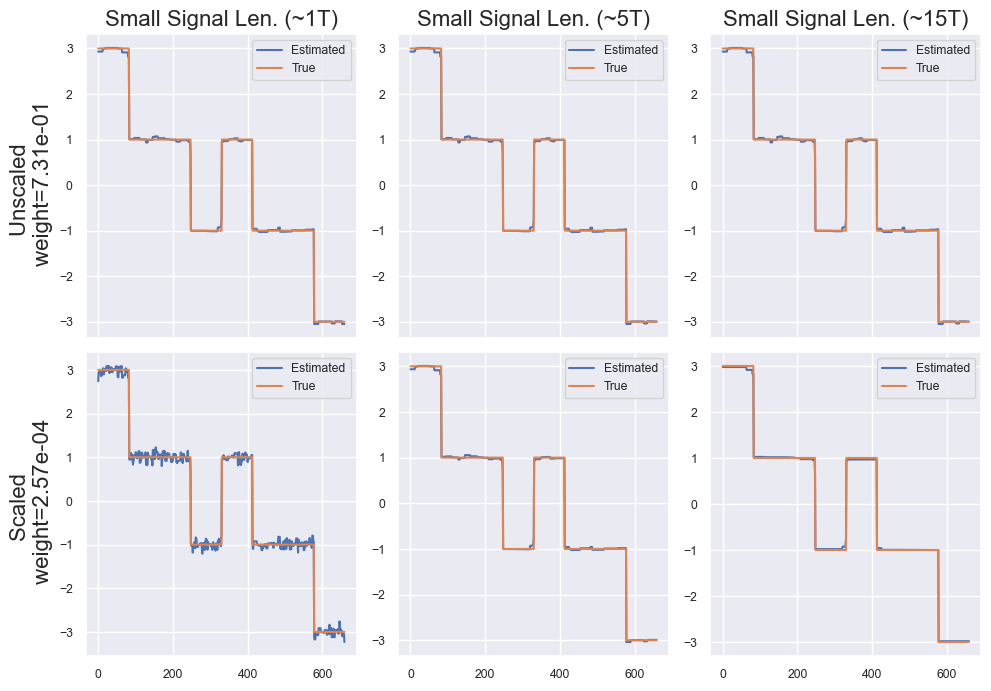

In [63]:
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=True, figsize=(10,7))
res_k = list(results.keys())

for ax_ in ax:
    for ax__, k in zip(ax_, res_k):
        ax__.plot(results[k]["s_seas_med"][:period], label="Estimated")
        ax__.plot(gt[:period], label="True")
        ax__.legend()
    res_k = res_k[3:]
        
ax[0][0].set_ylabel(f"Unscaled \n weight={weight_unscaled:.2e}", fontsize=16)
ax[1][0].set_ylabel(f"Scaled \n weight={weight_scaled:.2e}", fontsize=16)
ax[0][0].set_title("Small Signal Len. (~1T)", fontsize=16)
ax[0][1].set_title("Small Signal Len. (~5T)", fontsize=16)
ax[0][2].set_title("Small Signal Len. (~15T)", fontsize=16)

plt.tight_layout()

# Plot decomposition to check

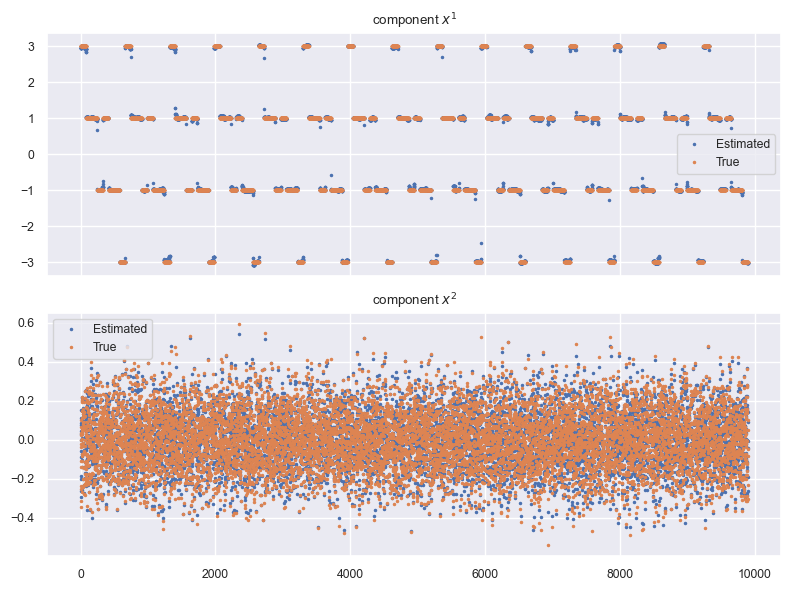

In [16]:
s_hat, s_err, obj = l2_l1d1_periodic(signal_large, weight=0.04167, l2="norm", scale=False)
plot_decomp([s_hat, s_err], [np.sum(X_real[:3], axis=0), X_real[3]])

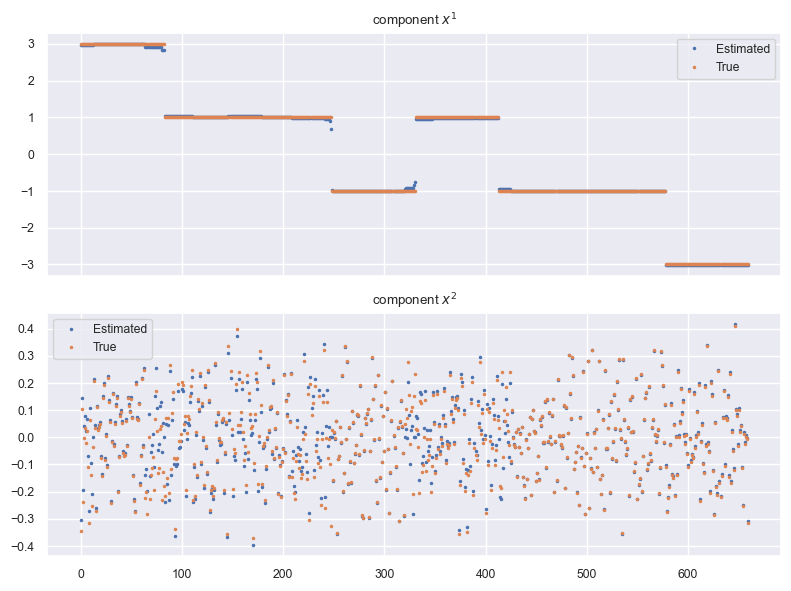

In [22]:
s_hat, s_err, _ = l2_l1d1_periodic(signal_small, weight=2.07e-3, l2="sumsquares", scale=True)
plot_decomp([s_hat, s_err], [np.sum(X_real[:3], axis=0)[:len(signal_small)], X_real[3][:len(signal_small)]])

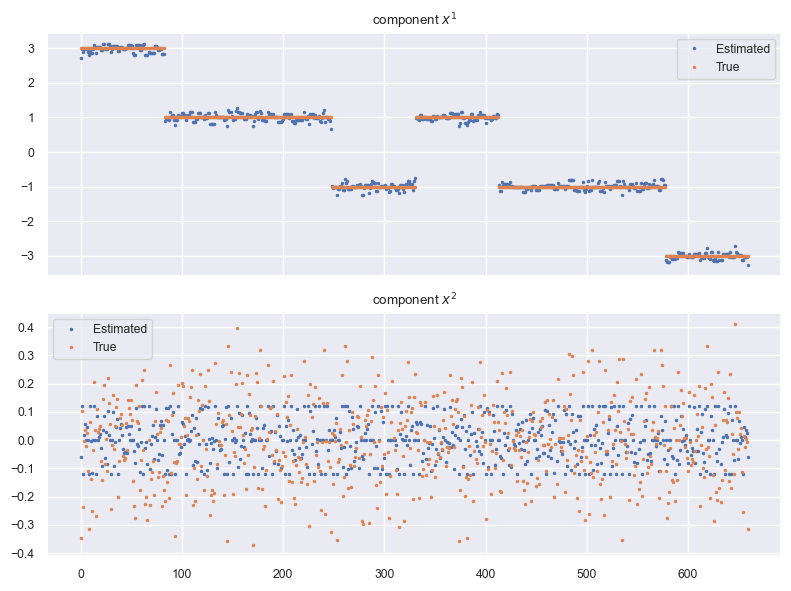

In [21]:
s_hat, s_err, _ = l2_l1d1_periodic(signal_small, weight=1.83e-4, l2="sumsquares", scale=True)
plot_decomp([s_hat, s_err], [np.sum(X_real[:3], axis=0)[:len(signal_small)], X_real[3][:len(signal_small)]])